In [10]:
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor
import tarfile,os
import re
import numpy as np
from torch import nn
import torch.nn.functional as F
from torch import optim

In [11]:
from fastprogress import master_bar, progress_bar
from fastprogress.fastprogress import format_time
from functools import partial
import time

#  Data Download/reading/processing

In [2]:
datasets??

In [7]:
CIFAR10_URL='http://files.fast.ai/data/examples/cifar10'

In [8]:
path = datasets.download_data(CIFAR10_URL, ext='.tgz'); path # path is PathLib object

WindowsPath('C:/Users/Sachin Bharadwaj/.fastai/data/cifar10.tgz')

In [4]:
??datasets.download_data

In [22]:
dest_dir =  "D:\\Steradian\\Personal\\GANs\\datasets\\"
with tarfile.open(path) as f:
    f.extractall(dest_dir)

In [12]:
dataset_dir = "D:\\Steradian\\Personal\\GANs\\datasets\\" + 'cifar10'
test_files = []
test_labels = []
train_files = []
train_labels = []
pat = r'([a-zA-Z]+).png$'
pat = re.compile(pat)
for currpath, folders, filenames in os.walk(dataset_dir):
    if 'train' in currpath:
        for fname in filenames:
            string = os.path.join(currpath,fname)
            train_files.append(string)
            label = pat.search(string).group(1)
            train_labels.append(label)
    elif 'test' in currpath:
        for fname in filenames:
            string = os.path.join(currpath,fname)
            test_files.append(string)
            label = pat.search(string).group(1)
            test_labels.append(label)

In [13]:
test_files[-10::]

['D:\\Steradian\\Personal\\GANs\\datasets\\cifar10\\test\\truck\\9868_truck.png',
 'D:\\Steradian\\Personal\\GANs\\datasets\\cifar10\\test\\truck\\9871_truck.png',
 'D:\\Steradian\\Personal\\GANs\\datasets\\cifar10\\test\\truck\\9875_truck.png',
 'D:\\Steradian\\Personal\\GANs\\datasets\\cifar10\\test\\truck\\9881_truck.png',
 'D:\\Steradian\\Personal\\GANs\\datasets\\cifar10\\test\\truck\\9884_truck.png',
 'D:\\Steradian\\Personal\\GANs\\datasets\\cifar10\\test\\truck\\9898_truck.png',
 'D:\\Steradian\\Personal\\GANs\\datasets\\cifar10\\test\\truck\\9927_truck.png',
 'D:\\Steradian\\Personal\\GANs\\datasets\\cifar10\\test\\truck\\9938_truck.png',
 'D:\\Steradian\\Personal\\GANs\\datasets\\cifar10\\test\\truck\\9958_truck.png',
 'D:\\Steradian\\Personal\\GANs\\datasets\\cifar10\\test\\truck\\9971_truck.png']

In [14]:
test_labels[-10::]

['truck',
 'truck',
 'truck',
 'truck',
 'truck',
 'truck',
 'truck',
 'truck',
 'truck',
 'truck']

(32, 32, 3)


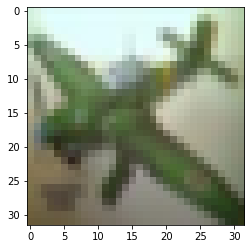

In [15]:
from PIL import Image
im = Image.open(test_files[200])
im
# using matplotlib
x = plt.imread(test_files[200])
print(x.shape)
plt.imshow(x)

In [16]:
# refactor code
def get_filelist_labellist(dataset_dir, pat):
    '''
    [1] dataset_dir : rootDIR where dataset is stored, ex: dataset_dir = "D:\\Steradian\\Personal\\GANs\\datasets\\" + 'cifar10'
    [2] regular expression for searching label from filenames, ex: pat = r'([a-zA-Z]+).png$'
    '''
    test_files = []
    test_labels = []
    train_files = []
    train_labels = []
    pat = re.compile(pat)
    for currpath, folders, filenames in os.walk(dataset_dir):
        if 'train' in currpath:
            for fname in filenames:
                string = os.path.join(currpath,fname)
                train_files.append(string)
                label = pat.search(string).group(1)
                train_labels.append(label)
        elif 'test' in currpath:
            for fname in filenames:
                string = os.path.join(currpath,fname)
                test_files.append(string)
                label = pat.search(string).group(1)
                test_labels.append(label)
                
    return train_files, train_labels, test_files, test_labels

In [17]:
dataset_dir = "D:\\Steradian\\Personal\\GANs\\datasets\\" + 'cifar10'
pat = r'([a-zA-Z]+).png$'
train_files_list, train_labels_list, test_files_list, test_labels_list  = get_filelist_labellist(dataset_dir, pat)

In [18]:
def get_data(file_list):
    data = []
    for f in file_list:
        data.append(plt.imread(f))
        
    return data

train_datalist = get_data(train_files_list)
test_datalist = get_data(test_files_list)

In [19]:
len(train_datalist), len(test_datalist)

(50000, 10000)

In [20]:
train_datalist[0].shape, test_datalist[0].shape

((32, 32, 3), (32, 32, 3))

In [21]:
len(train_labels_list), len(test_labels_list)

(50000, 10000)

In [22]:
# contruct label dictionary
label_file = dataset_dir + '\\labels.txt'
fh = open(label_file,'r')
label_dict = {}
c = 0
for l in fh:
    label_dict[l.rstrip()] = c #rstrip() removes all sorts of trailing spaces including /n
    c+=1    

In [23]:
label_dict

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [24]:
def get_labels(labellist, label_dict):
    labels = []
    for l in labellist:
        labels.append(label_dict[l])
    return labels

train_labels =  get_labels(train_labels_list, label_dict)  
test_labels =  get_labels(test_labels_list, label_dict)  

In [25]:
train_labels[-10::]

[9, 9, 9, 9, 9, 9, 9, 9, 9, 9]

In [26]:
len(train_datalist), len(train_labels)

(50000, 50000)

In [27]:
len(test_datalist), len(test_labels)

(10000, 10000)

In [28]:
train_data = np.array(train_datalist)
train_labels = np.array(train_labels)
test_data = np.array(test_datalist)
test_labels = np.array(test_labels)

In [29]:
train_data.shape, train_labels.shape

((50000, 32, 32, 3), (50000,))

In [30]:
x_train = train_data/255.0
x_test  = test_data/255.0

In [31]:
num_classes = len(label_dict.keys())

In [32]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]
#y_train = to_categorical(train_labels, num_classes)
#y_test  = to_categorical(test_labels, num_classes)
y_train = train_labels
y_test  = test_labels

In [33]:
# map to tensors
x_train,x_test,y_train,y_test = map(tensor,(x_train,x_test,y_train,y_test))

In [34]:
x_train.shape, y_train.shape

(torch.Size([50000, 32, 32, 3]), torch.Size([50000]))

# Architecture1- ANN

In [35]:
n_in = 32*32*3

In [36]:
class Flatten(nn.Module):
    def __init__(self, n_out):
        super().__init__()
        self.n_out = n_out
               
    def forward(self, x):
        return x.view(-1, self.n_out)


In [53]:
class MyNet(nn.Module):
    def __init__(self, module_list):
        super().__init__()
        self.layers = nn.ModuleList(module_list)
        
    def forward(self,x):
        for l in self.layers:
            x = l(x)
        return x

In [286]:
module_list = [Flatten(n_in), nn.Linear(n_in,200), nn.ReLU(), nn.Linear(200,150), nn.ReLU(), nn.Linear(150,num_classes)]        
model = MyNet(module_list)

In [287]:
# just checking
x_train[0:2].shape
pred = model(x_train[0:2])
pred.shape

torch.Size([2, 10])

In [288]:
#loss function 
F.cross_entropy(pred,y_train[0:2].long())

tensor(2.3261, grad_fn=<NllLossBackward>)

In [37]:
# choose the loss function
loss_func = F.cross_entropy

In [290]:
# choose the optimizer
opt = optim.Adam(model.parameters(), lr=1e-3)

In [291]:
model.parameters()

<generator object Module.parameters at 0x000001B133FB82B0>

In [292]:
for l in model.parameters():
    print(l)

Parameter containing:
tensor([[-0.0156, -0.0065, -0.0078,  ...,  0.0036, -0.0071,  0.0130],
        [-0.0127,  0.0151, -0.0045,  ...,  0.0159,  0.0031, -0.0147],
        [ 0.0131, -0.0055, -0.0116,  ...,  0.0108, -0.0083, -0.0095],
        ...,
        [-0.0072, -0.0115, -0.0057,  ...,  0.0028, -0.0126, -0.0180],
        [-0.0063, -0.0095, -0.0021,  ..., -0.0022, -0.0090,  0.0099],
        [-0.0006,  0.0142,  0.0033,  ...,  0.0109,  0.0024, -0.0163]],
       requires_grad=True)
Parameter containing:
tensor([ 1.2736e-02, -1.3886e-02,  1.2608e-02,  8.8550e-03, -2.8931e-03,
        -1.7318e-02,  5.9455e-04,  1.6414e-02, -1.1948e-02, -2.1564e-03,
        -1.7394e-02,  1.3424e-02, -4.3029e-03, -1.5711e-02, -1.3853e-02,
        -1.3323e-02,  3.1825e-03, -1.4452e-02, -1.1843e-02, -1.4190e-02,
        -1.2180e-02,  9.9436e-03, -9.2570e-03,  1.1056e-02, -1.7430e-02,
        -5.1045e-03, -1.2498e-02, -1.3544e-02, -8.1253e-03,  1.1739e-02,
        -1.0026e-02,  1.0912e-02, -7.3363e-03,  9.4976e-0

In [293]:
model.state_dict()

OrderedDict([('layers.1.weight',
              tensor([[-0.0156, -0.0065, -0.0078,  ...,  0.0036, -0.0071,  0.0130],
                      [-0.0127,  0.0151, -0.0045,  ...,  0.0159,  0.0031, -0.0147],
                      [ 0.0131, -0.0055, -0.0116,  ...,  0.0108, -0.0083, -0.0095],
                      ...,
                      [-0.0072, -0.0115, -0.0057,  ...,  0.0028, -0.0126, -0.0180],
                      [-0.0063, -0.0095, -0.0021,  ..., -0.0022, -0.0090,  0.0099],
                      [-0.0006,  0.0142,  0.0033,  ...,  0.0109,  0.0024, -0.0163]])),
             ('layers.1.bias',
              tensor([ 1.2736e-02, -1.3886e-02,  1.2608e-02,  8.8550e-03, -2.8931e-03,
                      -1.7318e-02,  5.9455e-04,  1.6414e-02, -1.1948e-02, -2.1564e-03,
                      -1.7394e-02,  1.3424e-02, -4.3029e-03, -1.5711e-02, -1.3853e-02,
                      -1.3323e-02,  3.1825e-03, -1.4452e-02, -1.1843e-02, -1.4190e-02,
                      -1.2180e-02,  9.9436e-03, -9.257

In [38]:
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [39]:
from torch.utils.data import Dataset

In [40]:
# Inherit the PyTorch Dataset class
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x, self.y = x, y
        
    def __getitem__(self, i): # called when you index into something
        return (self.x[i], self.y[i])
    
    def __len__(self):
        return len(self.x)
train_ds, test_ds = MyDataset(x_train,y_train), MyDataset(x_test,y_test)

In [41]:
# construct data loaders
bs = 32 #batch size
epochs = 1
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds))
test_dl  = DataLoader(test_ds, bs, sampler=SequentialSampler(test_ds))

In [42]:
def accuracy(pred, target):
    return (pred.argmax(-1) == target.long()).float().mean()

In [65]:
def fit(epochs, model, loss_func, opt, train_dl, test_dl):
    for epoch in range(epochs):
        # Handle batchnorm / dropout
        model.train()
#         print(model.training)
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb.long())
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
#         print(model.training)
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in test_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb.long())
                tot_acc  += accuracy (pred,yb)
        nv = len(test_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

In [304]:
epochs = 10
fit(epochs, model, loss_func, opt, train_dl, test_dl)

0 tensor(1.7461) tensor(0.3756)
1 tensor(1.6863) tensor(0.3933)
2 tensor(1.6650) tensor(0.4052)
3 tensor(1.6271) tensor(0.4177)
4 tensor(1.5981) tensor(0.4271)
5 tensor(1.5670) tensor(0.4428)
6 tensor(1.5602) tensor(0.4431)
7 tensor(1.5401) tensor(0.4523)
8 tensor(1.5216) tensor(0.4569)
9 tensor(1.5009) tensor(0.4648)


(tensor(1.5009), tensor(0.4648))

# Our Two hidden layer Network is about 47% accurate on test set (random probability of success is 10%)

## Lets view some of the predictions from the network

In [309]:
pred = model(x_test)
pred_label_id = pred.argmax(-1)

In [43]:
def labelidx_labels(label_dict, labelidx):
    '''
    [1] label_dict: dictionary where key is the text label and value is the mapping
    [2] labelidx: list of label idxs
    '''
    labels = []
    for l in labelidx:
        x = [key for key,value in label_dict.items() if value==l][0]
        labels.append(x)
    return labels

In [336]:
pred_labels = labelidx_labels(label_dict, pred_label_id)
true_labels = labelidx_labels(label_dict, y_test)

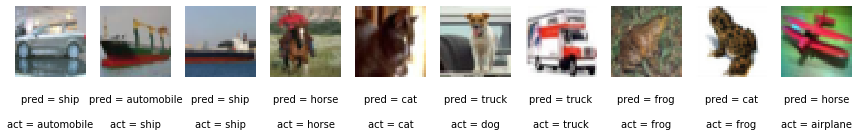

In [347]:
n_to_show = 10
indices  = np.random.choice(len(pred_labels),n_to_show)

fig = plt.figure(figsize=(15, 3))

for i, idx in enumerate(indices):
    img = test_data[idx]
    ax = fig.add_subplot(1, n_to_show, i+1)
    ax.axis('off')
    # transform=ax.transAxes -> The coordinate system of the Axes; (0, 0) is bottom left of the axes, and (1, 1) is top right of the axes.
    ax.text(0.5, -0.35, 'pred = ' + str(pred_labels[idx]), fontsize=10, ha='center', transform=ax.transAxes) 
    ax.text(0.5, -0.7, 'act = ' + str(true_labels[idx]), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img)

# Architecture2- CNN

In [44]:
x_train = train_data/255.0
x_test  = test_data/255.0
y_train = train_labels
y_test  = test_labels
# map to tensors
x_train,x_test,y_train,y_test = map(tensor,(x_train,x_test,y_train,y_test))

In [45]:
x_train_new = x_train.clone()
x_test_new  = x_test.clone()

In [46]:
x_test_new[0].dtype

torch.float32

In [47]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [48]:
x_train_new = x_train_new.permute(0,3,2,1)
x_test_new  = x_test_new.permute(0,3,2,1)

In [49]:
train_ds_new, test_ds_new = MyDataset(x_train_new,y_train), MyDataset(x_test_new,y_test)
train_dl_new = DataLoader(train_ds_new, bs, sampler=RandomSampler(train_ds_new))
test_dl_new  = DataLoader(test_ds_new, bs, sampler=SequentialSampler(test_ds_new))

In [50]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
        
    def forward(self, x):
        return self.func(x)
    
def flatten(x):
    return x.view(x.shape[0],-1)

def input_permute(x):
    return x.permute(0,3,1,2)

In [51]:
module_list = ([nn.Conv2d(3, 32, 3, padding=1, stride=1), nn.BatchNorm2d(32), nn.LeakyReLU(), 
               nn.Conv2d(32, 64, 3, padding=1, stride=2), nn.BatchNorm2d(64), nn.LeakyReLU(), 
               nn.Conv2d(64, 128, 3, padding=1, stride=2), nn.BatchNorm2d(128), nn.LeakyReLU(), 
               nn.Conv2d(128, 256, 3, padding=1, stride=2), nn.BatchNorm2d(256), nn.LeakyReLU(), 
               Lambda(flatten), 
               nn.Linear(4096,256), nn.BatchNorm1d(256), nn.LeakyReLU(), nn.Dropout(p=0.5), 
               nn.Linear(256,num_classes)])

In [54]:
model = MyNet(module_list)
# put the model on GPU
model.to(device)

MyNet(
  (layers): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Lambda()
    (13): Linear(in_features=4096, out_features=256, bias=True)
    (14): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True,

In [55]:
# choose the optimizer
opt = optim.Adam(model.parameters(), lr=1e-4)

In [56]:
# test few predictions
z = x_train_new[0:2].to(device)
pred = model(z)
pred.shape

torch.Size([2, 10])

In [117]:
# put the model on GPU
model.to(device)

MyNet(
  (layers): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Lambda()
    (13): Linear(in_features=4096, out_features=256, bias=True)
    (14): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True,

In [122]:
def fit(epochs, model, loss_func, opt, train_dl, test_dl):
    for epoch in range(epochs):
        # Handle batchnorm / dropout
        model.train()
#         print(model.training)
        for xb,yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            loss = loss_func(model(xb), yb.long())
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
#         print(model.training)
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in test_dl:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                tot_loss += loss_func(pred, yb.long())
                tot_acc  += accuracy (pred,yb)
        nv = len(test_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

In [126]:
epochs = 3
fit(epochs, model, loss_func, opt, train_dl_new, test_dl_new)

0 tensor(0.7776, device='cuda:0') tensor(0.7662, device='cuda:0')
1 tensor(1.1147, device='cuda:0') tensor(0.7047, device='cuda:0')
2 tensor(0.8005, device='cuda:0') tensor(0.7670, device='cuda:0')


(tensor(0.8005, device='cuda:0'), tensor(0.7670, device='cuda:0'))

In [367]:
x_test[0].shape

torch.Size([32, 32, 3])

###  some more refactoring of the code
1. Datasets are tuples (data,labels) for train/valid/test
2. DataLoaders are just generators for datasets, train_dl/valid_dl/test_dl
3. DataBunch is just convenience class which binds all dataloaders  together

In [57]:
class DataBunch():
    def __init__(self, train_dl, valid_dl, c):
        self.train_dl, self.valid_dl, self.c = train_dl, valid_dl, c
        
    @property
    def train_ds(self):
        return self.train_dl.dataset
    
    @property
    def valid_ds(self):
        return self.valid_dl.dataset

### Learner class just a convenience class which binds together (model, opt, loss_func, databunch_obj)

In [58]:
class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model = model
        self.opt   = opt
        self.loss_func = loss_func
        self.data = data

In [59]:
databunch = DataBunch(train_dl_new, test_dl_new, num_classes)
learn = Learner(model, opt, loss_func, databunch)

### redefine fit method  in terms of learn object

In [138]:
def fit(epochs, learn):
    for epoch in range(epochs):
        learn.model.train() # this sets the training flag as True (required for batchnorm, dropout behaviour being different in training vs. validation)
        for xb, yb in learn.data.train_dl:
            xb, yb = xb.to(device), yb.to(device)
            loss = learn.loss_func(model(xb), yb.long())
            loss.backward()
            learn.opt.step()
            learn.opt.zero_grad()
            
        learn.model.eval() # model in validation mode
        with torch.no_grad():
            tot_loss, tot_acc = 0.0, 0.0
            for xb, yb in learn.data.valid_dl:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                tot_loss += learn.loss_func(pred, yb.long())
                tot_acc  += accuracy(pred, yb.long())
            
            nv = len(learn.data.valid_dl)
            print(epoch, tot_loss/nv, tot_acc/nv)
        return tot_loss/nv, tot_acc/nv

In [139]:
val_loss, val_acc = fit(1, learn)

0 tensor(0.7745, device='cuda:0') tensor(0.7810, device='cuda:0')


###  Lets add CallBack

In [60]:
from collections.abc import Iterable
def listify(o):
    if o is None: return []
    if isinstance(o,list): return o
    if isinstance(o,str): return [o]
    if isinstance(o,Iterable): return list(o)
    return [o]

In [61]:
import re

_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')

def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()

class Callback():
    _order=0
    def set_runner(self, run): self.run=run
    def __getattr__(self, k): return getattr(self.run, k)
    
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')
    
    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        if f and f(): return True
        return False
    
class CancelTrainException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass

###  - TrainEvalCallback: 
reponsible to switch the model back and forth in training or validation mode, as well as maintaining a count of the iterations, or the percentage of iterations ellapsed in the epoch

In [62]:
class TrainEvalCallback(Callback):
    _order = 5 # make it low priority in running as compared to Base Callback class
    def begin_fit(self):
        self.run.n_epochs=0.
        self.run.n_iter=0
    
    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter   += 1
        
    def begin_epoch(self):
        self.run.n_epochs=self.epoch
        self.model.train()
        self.run.in_train=True

    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False

### Runner Class
Combines learn(model, loss_func, opt, dl), fit , callbacks together

In [63]:
class Runner():
    def __init__(self, cbs=None, cb_funcs=None): #cbs are callback inherited class object list, cb_funcs are just derived class names, their object are contructed in constructor
        cbs = listify(cbs) # listify all callback objects, if already a list, it does nothing
        for cbf in listify(cb_funcs): # this is just list of user defined call back classes
            cb = cbf() # create object out of class names
            # add these functions to current class object
            setattr(self, cb.name, cb) # cb.name is method defined in base CallBack class, note this is self.cb.name=cb() is defined in runner object, runner object gets passed to CallBack Base class using set_runner() in the fit() method of runner class and access to any method inside CallBack class look for getattr inside the runner object
            cbs.append(cb) # append to call back object list
        self.stop,self.cbs = False, [TrainEvalCallback()] + cbs #TrainEvalCallback() is setting self.in_train accordingly
    
    @property
    def opt(self): return self.learn.opt
    @property
    def model(self): return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self): return self.learn.data
    
    def one_batch(self, xb, yb):
        self.xb, self.yb = xb, yb
        if self('begin_batch'): return
        self.pred = self.model(xb)
        if self('after_pred'): return
        self.loss = self.loss_func(self.pred, yb.long())
        if self('after_loss') or not self.in_train: return
        self.loss.backward()
        if self('after_backward'): return
        self.opt.step()
        if self('after_step'): return
        self.opt.zero_grad()
        
    def all_batches(self, dl):
        self.iters = len(dl)
        for xb,yb in dl:
            if self.stop: break
            xb, yb = xb.to(device), yb.to(device)
            self.one_batch(xb, yb)
            self('after_batch')
        self.stop=False
        
    def fit(self, epochs, learn):
        self.epochs,self.learn = epochs,learn
        
        try:
            for cb in self.cbs: 
                #set_trace()
                cb.set_runner(self)
                
            if self('begin_fit'): return
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)

                with torch.no_grad(): 
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                
                
                if self('after_epoch'): break
            
        finally:
            self('after_fit')
            self.learn = None
        
    def __call__(self, cb_name):
        for cb in sorted(self.cbs, key=lambda x: x._order): # callbacks object are run based on _order property ordering
            f = getattr(cb, cb_name, None)
            if f and f(): return True
        return False # returning False is normal behaviour in runner class for calling callbacks
    

In [64]:
train_eval = TrainEvalCallback()
run = Runner(cbs = [train_eval])

In [65]:
run.fit(2, learn)

### define callback  to print train/valid accuracy

In [66]:
class AvgStats():
    def __init__(self, metrics, in_train):
        self.metrics, self.in_train = listify(metrics), in_train
        
    def reset(self):
        self.tot_loss, self.count = 0., 0.
        self.tot_mets = [0.] * len(self.metrics)
        
    @property
    def all_stats(self): return [self.tot_loss.item()] + self.tot_mets
    @property
    def avg_stats(self): return [o/self.count for o in self.all_stats]
    
    def __repr__(self):
        if not self.count: return ""
        return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"
        
    def accumulate(self, run): # this is passed run object explicitly since it does not inherits Callback
        bn = run.xb.shape[0]
        self.tot_loss += run.loss * bn
        self.count += bn
        for i,m in enumerate(self.metrics):
            self.tot_mets[i] += m(run.pred, run.yb.long()) * bn
        
        
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats, self.valid_stats = AvgStats(metrics,True), AvgStats(metrics,False)
    
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run) 
            
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)
        

In [67]:
stats = AvgStatsCallback([accuracy])
train_eval = TrainEvalCallback()
run = Runner(cbs = [train_eval,stats])
run.fit(2, learn)

train: [0.964866953125, tensor(0.6666, device='cuda:0')]
valid: [1.144591015625, tensor(0.5917, device='cuda:0')]
train: [0.815628671875, tensor(0.7201, device='cuda:0')]
valid: [13.6739609375, tensor(0.1020, device='cuda:0')]


### redefine AvgStatsCallBack

In [68]:
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
    
    def begin_fit(self):
        met_names = ['loss'] + [m.__name__ for m in self.train_stats.metrics]
        names = ['epoch'] + [f'train_{n}' for n in met_names] + [
            f'valid_{n}' for n in met_names] + ['time']
        self.logger(names)
    
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        self.start_time = time.time()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    def after_epoch(self):
        stats = [str(self.epoch)] 
        for o in [self.train_stats, self.valid_stats]:
            stats += [f'{v:.6f}' for v in o.avg_stats] 
        stats += [format_time(time.time() - self.start_time)]
        self.logger(stats)

### Add progressBar as Callback

In [83]:
class ProgressCallback(Callback):
    _order=-1
    def begin_fit(self):
        self.mbar = master_bar(range(self.epochs))
        self.mbar.on_iter_begin()
        self.run.logger = partial(self.mbar.write, table=True)
        
    def after_fit(self): self.mbar.on_iter_end()
    def after_batch(self): self.pb.update(self.iters)
    def begin_epoch   (self): 
        self.dl = self.run.data.train_dl
        self.set_pb()
    def begin_validate(self): 
        self.dl = self.run.data.valid_dl
        self.set_pb()
        
    def set_pb(self):
        self.pb = progress_bar(self.dl, parent=self.mbar, auto_update=False)
        self.mbar.update(self.epoch)

In [88]:
cbfs = [partial(AvgStatsCallback,accuracy), TrainEvalCallback,
        ProgressCallback]

In [90]:
run = Runner(cb_funcs = cbfs)
run.fit(2, learn)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.308091,0.897540,3.559078,0.313200,00:33
1,0.257903,0.916320,6.232309,0.251700,00:33
